<a href="https://colab.research.google.com/github/Goro-python/my_NLP/blob/master/microModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# # Uploading the Data 

from google.colab import files
upload = files.upload()


Saving modelling_data_ver2.csv to modelling_data_ver2.csv


In [4]:
!pip install tensorflow==2.3.0
!pip install transformers

     |████████████████████████████████| 320.4MB 55kB/s 
     |████████████████████████████████| 20.1MB 97kB/s 
     |████████████████████████████████| 460kB 30.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


     |████████████████████████████████| 2.0MB 4.3MB/s 
     |████████████████████████████████| 3.3MB 38.3MB/s 
     |████████████████████████████████| 870kB 36.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=eb694f7d1daea23758b4f3173bd5b2b20c1a66fca97382eb3d89c21acf0452d5
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
tf.__version__

'2.3.0'

In [2]:
df = pd.read_csv("modelling_data_ver2.csv")


In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
le = LabelEncoder()
df[' labelledField'] = le.fit_transform(df[' labelledField'])

In [5]:
df[' labelledField'].nunique()

52

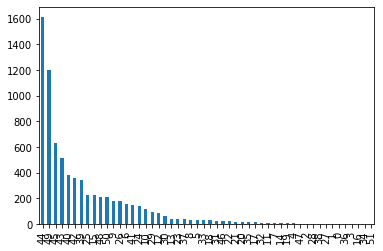

In [6]:
df[' labelledField'].value_counts().plot.bar()

In [7]:
label = df[' labelledField'].values
sentences = df.X.values

In [8]:
# convert to tokenizer
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_train,x_test,y_train,y_test = train_test_split(sentences,label,test_size = 0.2)

In [11]:
# encoding 
encoded_train = tokenizer.batch_encode_plus(
            x_train,
            padding = 'longest',
        )
train_input_ids = np.array(encoded_train["input_ids"],dtype = "int32")
train_att_mask =  np.array(encoded_train["attention_mask"],dtype="int32")


In [12]:
maxLength = train_input_ids.shape[1]

In [13]:
# test data set up
max_length = maxLength
encoded_test = tokenizer.batch_encode_plus(
            x_test,
            add_special_tokens=True,
            max_length=max_length,
            return_attention_mask=True,
            return_token_type_ids=True,
            pad_to_max_length=True)

# test data 

test_input_ids = np.array(encoded_test["input_ids"],dtype = "int32")
test_att_mask =  np.array(encoded_test["attention_mask"],dtype="int32")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [15]:
test_input_ids.shape

(1505, 65)

In [16]:
from transformers import TFBertModel
np.random.seed(4)
max_length = maxLength

def createModel():
  """ create the model for Android Form Fill with BERT Tokenizer """
  input_ids = tf.keras.layers.Input(
          shape=(max_length,), dtype=tf.int32, name="input_ids")
      # Attention masks indicates to the model which tokens should be attended to.
  attention_masks = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="attention_masks")
      # Token type ids are binary masks identifying different sequences in the model.
  bert_model = TFBertModel.from_pretrained("bert-base-uncased")
      # Freeze the BERT model to reuse the pretrained features without modifying them.
  bert_model.trainable = False
  bert_out = bert_model(input_ids, attention_mask=attention_masks)
  print(bert_out)
  sequence_output = bert_out["last_hidden_state"]
  print(sequence_output)
  # Add trainable layers on top of frozen layers to adapt the pretrained features on the new data.
  bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
      # Applying hybrid pooling approach to bi_lstm sequence output.
  avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
  max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
  concat = tf.keras.layers.concatenate([avg_pool, max_pool])
  dropout = tf.keras.layers.Dropout(0.3)(concat)
  output = tf.keras.layers.Dense(52, activation="softmax")(dropout)
  model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
  model.compile(optimizer=tf.keras.optimizers.Adam(),
          loss= "sparse_categorical_crossentropy",
          metrics=["accuracy"],run_eagerly= True)

  model.summary()
  return model

In [17]:
nd_to_nd_autofill_bert = createModel()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience= 2)
full_model_hist =  nd_to_nd_autofill_bert.fit(x = [train_input_ids,train_att_mask], y = y_train, batch_size = 32,  epochs = 5, validation_data = ([test_input_ids,test_att_mask],y_test),callbacks = [early_stopping])

Epoch 1/5
189/189 [==============================] - 168s 889ms/step - loss: 0.8939 - accuracy: 0.7642 - val_loss: 0.9218 - val_accuracy: 0.7522
Epoch 2/5
189/189 [==============================] - 168s 887ms/step - loss: 0.8308 - accuracy: 0.7778 - val_loss: 0.9039 - val_accuracy: 0.7668
Epoch 3/5
189/189 [==============================] - 167s 886ms/step - loss: 0.7848 - accuracy: 0.7856 - val_loss: 0.9052 - val_accuracy: 0.7628
Epoch 4/5
189/189 [==============================] - 168s 888ms/step - loss: 0.7570 - accuracy: 0.7947 - val_loss: 0.8703 - val_accuracy: 0.7814
Epoch 5/5
189/189 [==============================] - 168s 887ms/step - loss: 0.7325 - accuracy: 0.7986 - val_loss: 0.8495 - val_accuracy: 0.7761


In [34]:
y_train.shape

(6017,)

In [21]:
# precison and recall
y_true =    y_test
predicts =  nd_to_nd_autofill_bert.predict([test_input_ids,test_att_mask])

macroLabel = []
y_pred = [np.argmax(pred) for pred in predicts]

In [24]:
from sklearn.metrics import precision_recall_fscore_support
prec,rec,f1,support = precision_recall_fscore_support(y_true, y_pred,average=None,labels=[i for i in range(52)])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0, 0.5, 'Precision')

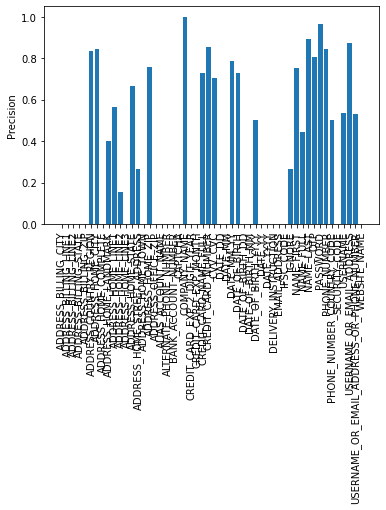

In [29]:
from matplotlib import pyplot as plt
plt.bar(x=le.inverse_transform([i for i in range(52)]), height = f1)
plt.xticks(rotation = 90)
plt.ylabel("Precision")

In [31]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_true,y_pred)

0.7523699380142584